<img src='https://www.sharif.edu/documents/20124/0/logo-fa-IR.png' alt="SUT logo" width=300 height=300 align=left class="saturate">



<!-- http://www-scf.usc.edu/~ghasemig/images/sharif.png -->

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2023<br>
<font color=3C99D size=5>
    Practical Assignment 5 - Decision Tree <br>
<font color=696880 size=4>
    Javad Hezareh

____

## Part0 - Personal Data

In [ ]:
Name = 'MohammadReza Ahmadi Teshnizi'
Student_Number = '98170646'

## Part1 - Decision Tree Implementation (60 Points)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In this part, we are going to implement the DecisionTree class from scratch. You are not allowed to use sklearn or any sklearn-like packages which have a built-in implementation of DecisionTree. You are expected to learn about the inner working of decision trees.

### 1.1 Dataset

We will use the *Pima Indians Diabetes* dataset to evaluate our implementation. This dataset consists of 768 records of patients and the goal is to predict whether or not a patient has diabetes.


If you use google colab you need to upload your kaggle.json file. If you want to continue locally you need to download the dataset from [here](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) and unzip it in *dataset* directory.

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/diabetes.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### 1.2 Model Implementation (45 Points)

As you know, in each node of the decision tree we need to choose among all features the best one. One can use different criteria to rank features but here we will use Information Gain. Complete the following functions to use later in the process of learning the decision tree.

In [ ]:
def entropy(y: pd.Series):
    """
    Return the entropy of input y.
    """
    classes = y.unique()
    entropy_value = 0
    total_samples = len(y)

    for c in classes:
        p = (y == c).sum() / total_samples
        entropy_value -= p * np.log2(p)

    return entropy_value

def information_gain(x: pd.Series, y: pd.Series):
    """
    Return the information gain of feature x.
    """
    total_entropy = entropy(y)
    unique_values = x.unique()
    weighted_entropy = 0

    for value in unique_values:
        subset_indices = x == value
        subset_entropy = entropy(y[subset_indices])
        subset_weight = sum(subset_indices) / len(x)
        weighted_entropy += subset_weight * subset_entropy

    information_gain_value = total_entropy - weighted_entropy
    return information_gain_value

def information_gains(X: pd.DataFrame, y: pd.Series):
    """
    Return the information gain of all features in X.
    """
    information_gains_dict = {}

    for feature in X.columns:
        information_gain_value = information_gain(X[feature], y)
        information_gains_dict[feature] = information_gain_value

    return information_gains_dict 

To implement decision tree structure we the use following class. Each node in the tree is an instance of class `Node` which is capable of predicting and fitting.

- In the `fit` function this node gets features and labels from its father and using information gain decides which feature to use. Also based on the decided class it will create its children and call their fit function passing relevant features and labels.
- In the `predict` function this node gets features as input and based on its best_feature decides on this input. If this node is a leaf, it will return the decision imediatly and if it's not a leaf, it will return the prediction of its decided child.

In [ ]:
class Node:
    def __init__(self, depth):
        self.depth = depth
        self.best_feature = ''
        self.children = []

    def _is_leaf(self):
        return len(self.children) == 0

    def fit(self, X_train, y_train):
        """
        Learn the best_feature and create the children of this node.
        """
        if len(X_train) == 0 or len(X_train.columns) == 0:
            return

        information_gains_dict = information_gains(X_train, y_train)
        self.best_feature = max(information_gains_dict, key=information_gains_dict.get)

        unique_values = X_train[self.best_feature].unique()
        for value in unique_values:
            child = Node(self.depth + 1)
            self.children.append(child)
            subset_indices = X_train[self.best_feature] == value
            child.fit(X_train[subset_indices].drop(columns=self.best_feature), y_train[subset_indices])

    def predict(self, X):
        """
        Predict the class of X based on this node's best_feature.
        """
        if self._is_leaf() or self.best_feature not in X.columns:
            return None

        value = X[self.best_feature].iloc[0]
        for child in self.children:
            if value == child.best_feature:
                return child.predict(X.drop(columns=self.best_feature))
                
        return self.majority_class

### 1.3 Training & Testing (15 Points)

Now we can learn a decision tree to classify our dataset.

In [ ]:
X = df.drop(columns='Outcome')
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
dt = Node(depth=0)
dt.fit(X_train, y_train)

In [ ]:
dt.majority_class = y_train.value_counts().idxmax()

In [ ]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

y_pred_train = [dt.predict(X_train.iloc[[i]]) for i in range(len(X_train))]
y_pred_test = [dt.predict(X_test.iloc[[i]]) for i in range(len(X_test))]

train_accuracy = accuracy(y_train, y_pred_train)
test_accuracy = accuracy(y_test, y_pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.6530944625407166
Test Accuracy: 0.6428571428571429


## Part2 - Towards Interpretable Models (40 Points)

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from os import listdir
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

### 2.1 Introduction

Later in the course, you will learn about more complex yet easy-to-use machine learning models such as CNNs which have reached state-of-the-art results in different tasks. But one of the problems of these models is the ability to interpret the output. However, models such as decision trees are more interpretable. In this part, we want to train a decision tree model for image classification. We will use the *Cropped Yale Face* dataset that contains images of 32 unique faces. You are expected to learn about the sklearn built-in decision tree model and how to train it. Also, you will learn about some preprocessing and hyperparameter tuning. Feel free to use anything you need from the sklearn package.

If you use google colab you need to upload your kaggle.json file. If you want to continue locally you need to download the dataset from [here](https://www.kaggle.com/datasets/tbourton/extyalebcroppedpng) and unzip it in the *dataset* directory.

In [ ]:
# !cp kaggle.json /root/.kaggle/
# !kaggle datasets download -d tbourton/extyalebcroppedpng
# !unzip extyalebcroppedpng.zip -d ./dataset/

### 2.2 Preprocess (10 Points)
The following cell reads dataset images and saves them in a numpy array `X`. Also, labels that are the id of the subject are stored in `y`.

In [ ]:
# no need to change this cell (but i changed the paths!)
X = []
y = []
standard_size = (192, 168)

for p in listdir('/content/drive/MyDrive/Colab Notebooks/archive/CroppedYalePNG'):
    img = Image.open(f'/content/drive/MyDrive/Colab Notebooks/archive/CroppedYalePNG/{p}').convert('L')
    if img.size != (168, 192):
        continue
    img = np.array(img).reshape(-1)
    X.append(img)
    id = p[5:7]
    y.append(int(id))
X = np.array(X)
y = np.array(y)

standard_size, X.shape, y.shape

((192, 168), (2424, 32256), (2424,))

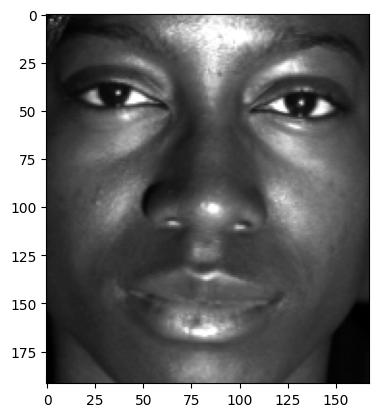

In [ ]:
# one sample of dataset
plt.imshow(Image.fromarray(X[0].reshape(standard_size)), cmap='gray');

We want to use PCA for dimensionality reduction, so first let's normalize our data:

In [ ]:
X_normal = (X - np.mean(X)) / np.std(X)

Now run the PCA model on normalized data: (read [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for PCA)

In [ ]:
pca = PCA()
p_components = pca.fit_transform(X_normal)

len(p_components)

2424

We need to decide on the number of PCA components to use. This is a hyperparameter and Later we might want to use a grid search to tune it. However here to have a better intuition for the range of our search and choose a candidate we can plot the graph of explained variance ratio of different components. You can find these values in `explained_variance_ratio_` attribute of your PCA object.

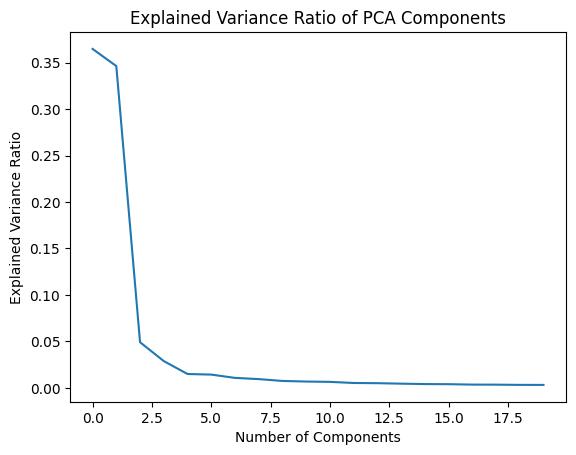

In [ ]:
x = list(range(20))
explained_variance_ratio = pca.explained_variance_ratio_[:20]

plt.plot(x, explained_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of PCA Components')
plt.show()

You can decide on the number of components to use by examining the above graph. Where the graph gets flat or you see an elbow is a good candidate.

In [ ]:
predicted_pca_components = 10

To get a better sense of your data it is valuable to show your PCA components. You can find components in `components_` attribute of your PCA object. Select `2 * predicted_pca_components` first number of them and plot them.

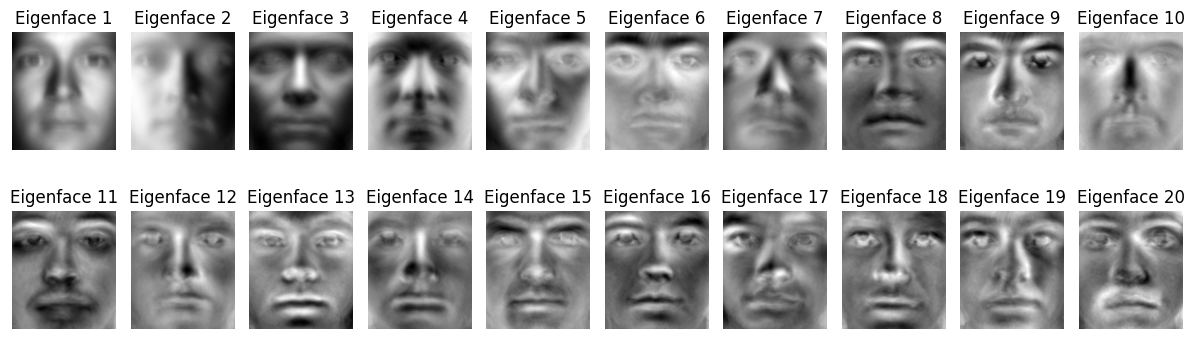

In [ ]:
import math

fig, axes = plt.subplots(2, predicted_pca_components, figsize=(12, 4))

components = pca.components_[:2 * predicted_pca_components]

for i, ax in enumerate(axes.flat):
    eigenface = components[i].reshape(standard_size)
    ax.imshow(eigenface, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Eigenface {i+1}')

plt.tight_layout()
plt.show()


Now you need to project all data on the space of PCA components. If $X$ is our data and $E$ is the matrix of PCA components, then the projection of $X$ on the space spanned by $E$ will be $X\cdot E^T$.

In [ ]:
X_pca = np.dot(X_normal, pca.components_.T)

### 2.3 Train and Test Model on the Entier Features (10 Points)

Now you have reduced the dimensionality of your data and you can train a decision tree on these features. But first let's train a decision tree on the entire features.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
full_dt = DecisionTreeClassifier()
full_dt.fit(X_train, y_train)

DecisionTreeClassifier()

Let's evaluate this model:

In [ ]:
y_pred = full_dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
num_nodes = full_dt.tree_.node_count
max_depth = full_dt.tree_.max_depth

accuracy, confusion_mat, num_nodes, max_depth

(0.7443298969072165,
 array([[ 7,  0,  1, ...,  0,  0,  0],
        [ 0,  4,  0, ...,  0,  1,  0],
        [ 0,  0,  8, ...,  0,  1,  0],
        ...,
        [ 0,  0,  0, ..., 10,  0,  0],
        [ 0,  0,  0, ...,  0, 10,  0],
        [ 0,  1,  0, ...,  0,  0, 13]]),
 489,
 54)

### 2.4 Train and Test model on the Reduced Features (10 Points)

Now use reduced features to train your decision tree classifer.

In [ ]:
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
reduced_dt = DecisionTreeClassifier()
reduced_dt.fit(X_pca_train, y_train)

DecisionTreeClassifier()

Report evaluation of decision tree trained on reduce data:

In [ ]:
y_pred_reduced = reduced_dt.predict(X_pca_test)

accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
confusion_mat_reduced = confusion_matrix(y_test, y_pred_reduced)
num_nodes_reduced = reduced_dt.tree_.node_count
max_depth_reduced = reduced_dt.tree_.max_depth

accuracy_reduced, confusion_mat_reduced, num_nodes_reduced, max_depth_reduced

(0.5175257731958763,
 array([[ 6,  0,  1, ...,  0,  0,  0],
        [ 0,  4,  2, ...,  0,  0,  0],
        [ 2,  1,  7, ...,  2,  0,  0],
        ...,
        [ 1,  0,  2, ...,  4,  1,  0],
        [ 1,  1,  1, ...,  0, 12,  0],
        [ 0,  0,  0, ...,  1,  1,  6]]),
 1109,
 49)

### 2.5 Hyperparameter Tuning (10 Points + 10 Optional)

If you did everything right, you would see that the accuracy of the decision tree trained on reduced data is not even close to the previous one using the entire features. Now try to tune hyperparameters `max_depth` and `number_of_pca_components` (optional) to get close to the previous model or even perform better than that. You need to perform a grid search on the value of these parameters and use cross-validation to choose the best ones. (read [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for sklearn grid search module)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

param_grid = {
    'decision_tree__max_depth': [5, 10, 15, 20],
    'pca__n_components': [5, 10, 15, 20]
}

pipeline = Pipeline([
    ('pca', PCA()),
    ('decision_tree', DecisionTreeClassifier())
])

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_max_depth = grid_search.best_params_['decision_tree__max_depth']
best_pca_n_components = grid_search.best_params_['pca__n_components']


In [ ]:
best_pipeline = Pipeline([
    ('pca', PCA(n_components=best_pca_n_components)),
    ('decision_tree', DecisionTreeClassifier(max_depth=best_max_depth))
])

best_pipeline.fit(X_train, y_train)


Pipeline(steps=[('pca', PCA(n_components=20)),
                ('decision_tree', DecisionTreeClassifier(max_depth=20))])

In [ ]:
y_pred_tuned = best_pipeline.predict(X_test)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
confusion_mat_tuned = confusion_matrix(y_test, y_pred_tuned)
num_nodes_tuned = best_pipeline.named_steps['decision_tree'].tree_.node_count
max_depth_tuned = best_pipeline.named_steps['decision_tree'].tree_.max_depth

accuracy_tuned, confusion_mat_tuned, num_nodes_tuned, max_depth_tuned


(0.5298969072164949,
 array([[ 5,  0,  0, ...,  0,  0,  1],
        [ 0,  6,  0, ...,  1,  0,  0],
        [ 1,  0,  9, ...,  1,  0,  0],
        ...,
        [ 3,  0,  2, ...,  8,  0,  0],
        [ 2,  0,  0, ...,  0, 13,  0],
        [ 0,  0,  1, ...,  0,  0,  8]]),
 1007,
 20)